# Comparing Parameterizations

In this notebook, we'll review tools for running and comparing subgrid parameterizations.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

## Run baseline high- and low-resolution models

In [3]:
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.82e-04, CFL: 0.051


In [4]:
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.85e-04, CFL: 0.221


## Run Smagorinsky and backscatter parameterizations

In [6]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.72e-04, CFL: 0.039
INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.55e-04, CFL: 0.041


## Compute similarity metrics between parameterized and high-resolution simulations

Similarity metrics quantify the percentage closer a diagnostic is to high resolution than low resolution; values greater than 0 indicate improvement over low resolution (with 1 being the maximum), while values below 0 indicate worsening. We can compute these for all diagnostics for all four simulations:

In [30]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.uv_parameterization or sim.q_parameterization or 'unparameterized'}"

sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res)) 
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,...,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=1.1)",0.483527,0.534461,0.502549,0.710110,...,0.402600,0.715061,0.517761,0.385973,0.826959
2,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,"nx=64, Smagorinsky(Cs=0.08)",-0.028367,0.348738,-0.118404,-0.184118,...,-0.141912,0.421832,-0.052879,-0.183343,0.179353


Note that the high-resolution and low-resolution models themselves have similarity scores of 1 and 0 by definition. In this case, the backscatter parameterization is consistently closer to high-resolution than low-resolution, while the Smagorinsky is consistently further.

Let's plot some of the actual curves underlying these metrics to get a better sense:

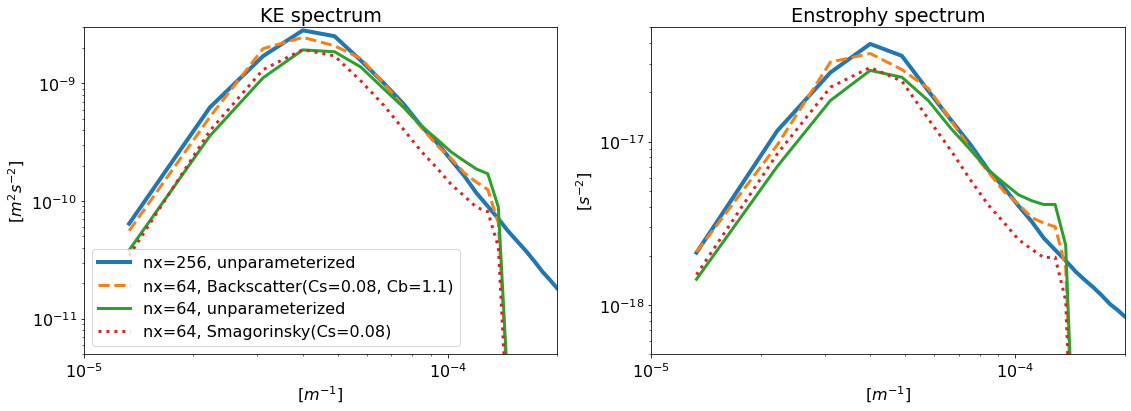

In [51]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(5e-12,3e-9)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(5e-19,5e-17)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()

The backscatter model, though low-resolution, has energy and enstrophy spectra that more closely resemble those of the high-resolution model.